##  Moebius transformation applied to a discrete image ##

 The aim of this notebook is to illustrate how a Moebius transformation, defined by its action on three points, distorts a  discrete image.
A Mobius transformation acts as a geometric transformation of an image, defined via the function
`geometric_transform` from `scipy.ndimage.interpolation`.

In image processing, a geometric transformation of an image consists in modifying
the positions of pixels in that image, but keeping
their colors unchanged.

In order to define a geometric transformation, as it is implemented in `scipy.ndimage`, we fix some background:

An image of resolution $m\times n$ is interpreted as a mapping
$$img:\{0,1, \ldots, m-1\}\times \{0,1, \ldots, n-1\}\to\mathbb{R}^3 (\mathbb{R}^4),$$
defined by $img(k,l)=(r,g,b)$ or (r, g, b, a), i.e. to the pixel in the row k, column l, one 
associates its color code (r, g, b) or (r, g, b, a).  
    
The  position of a pixel, $(k, l)$, is also given by its  coordinates $(x=l, y=k)$,
 with respect     to the image system of axes, $Oxy$, where $O$ is the left-upper corner, $Ox$ points horizontally to the right,  and $Oy$ downwards.

The geometric transformation, as a mapping from image to a planar region, is  given in the world coordinate system, XO'Y,  with O' usually chosen as being  the lower left corner of the image.

We have the following relationship between the world coordinates, $(X,Y)$, and image coordinates, $(x,y)$, of a pixel:
    
$$ \begin{array}{lll} 
X&=&x\\
Y&=&m-1-y
\end{array}
$$

Denoting by $D$ the rectangular region that covers  our image, 
a geometric transformation  is an invertible map $T:D\to D'\subset \mathbb{R}^2$. The transformation $T$ is chosen such that  the transformed image has common regions with the original one, i.e. $T(D)\cap D\neq \emptyset$.
    

 The geometric transformation implemented in `scipy.ndimage`  works as [follows](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/ndimage.html): theoretically one defines the output image (i.e. the deformed image) as an image of the same resolution (or not) with the input image. For each point P in the output image  one evaluates $T^{-1}(P)$. 
 - If $T^{-1}(P)$ is a pixel   in the input image,  one assigns to P the color of $T^{-1}(P)$.
 - If $T^{-1}(P)$ is not just a  pixel ( a point of integer coordinates),  one assigns a color to P, through a spline interpolation of the colors of neighbouring pixels of $T^{-1}(P)$.  
 - If $T^{-1}(P)$  is outside the rectangle that covers the input image, then $P$  is filled by a prescribed method. 
 

The Python function that implements $T^{-1}$, let us call it `inverse_map`,  has as a first mandatory parameter, a tuple of length equal to the output array (image) rank, and returns  a tuple of length equal to the input array (image) rank (recall that the rank of a `ndarray` is the length of its shape).

The `scipy.ndimage.interpolation.geometric_transform` that applies the transformation $T$  to an image, `img`, is defined as follows:

`geometric_transform(img, inverse_mapping, output_shape=None,  output=None, order=3, mode='constant',
                     cval=0.0, prefilter=True, extra_arguments=(),extra_keywords={})`    

- `order` sets the order of the spline interpolation;
- `mode` is a key that sets the method of filling the points P, for which $T^{-1}(P)$ is not in img.
   The options are: 'constant' (all such points are colored with the same color), 'nearest', 'reflect' or 'wrap';
   default is 'constant'.
- `cval` has effect when mode='constant'. It gives the  grey color code, between 0 and 255 (for jpg images), to fill the regions consisting in points that are not mapped by $T^{-1}$ in img.
- `extra_arguments=()` is a tuple defining the arguments of inverse_mapping, other than the mandatory one, defined above;
- for other keywords see [scipy docs](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.interpolation.geometric_transform.html).

Next we show how to apply a Moebius transform, $T(z)=(az+b)/(cz+d)$, $ad-bc\neq0$, to a color image.
The inverse map is defined by  $T^{-1}(z)=(dz-b)/(-cz+a)$.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import geometric_transform

Our color image has the shape $(m, n, 3)$. Hence the `inverse_map` has as a mandatory first parameter, a tuple of len(3):

In [3]:
def inv_Moebius_transform(index, a, b, c, d, img): 
    #index[0] gives the row of a pixel in the  output image, 
    #index[1] the column, and index[2], the color channel
    #a, b, c, d are the Moebius transform coeffcients and img is the output image (ndarray)                                        
    
    z = index[1] + 1j*(img.shape[0]-1-index[0])#the complex number associated to a pixel (to the corresponding 
                                               # point expressed in coordinates X,Y)
    w = (d*z-b)/(-c*z+a) #T^{-1}(z)
    return     img.shape[0]-1-np.imag(w), np.real(w), index[2] #returns the "approx row, and column" 
                                                               # for  T^{-1}(z)

In [4]:
plt.rcParams['figure.figsize'] = (8,6)

Read the image, img:

image shape (512L, 512L, 3L)


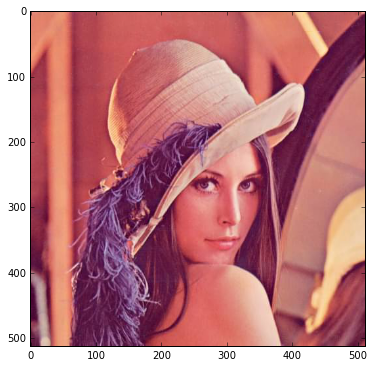

In [5]:
img=plt.imread('lenajpg.jpg')
plt.imshow(img)
print 'image shape', img.shape

Define the Moebius transformation that maps three points,  zp[i], in Lena's image referenced to XO'Y, to three points, wp[i], i=0,1,2, referenced to the same system of coordinates:

In [6]:
z1=300+1j*230
w1=np.exp(1j*np.pi/11)*z1  #z1 is rotated counter-clockwise about O' with  pi/11 to get w1
zp=[z1, 20+250*1j, 400+1j*180 ]#zp[1] is a fixed point, zp[2] is translated vertically
wp=[w1, 20+250*1j, 400+1j*210]

The coefficients, a, b, c, d, of the corresponding Moebius transformation are computed as
[follows](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation#Specifying_a_transformation_by_three_points):

In [7]:
a = np.linalg.det([[zp[0]*wp[0], wp[0], 1], 
                   [zp[1]*wp[1], wp[1], 1], 
                   [zp[2]*wp[2], wp[2], 1]])

b = np.linalg.det([[zp[0]*wp[0], zp[0], wp[0]], 
                   [zp[1]*wp[1], zp[1], wp[1]], 
                   [zp[2]*wp[2], zp[2], wp[2]]])         

c = np.linalg.det([[zp[0], wp[0], 1], 
                   [zp[1], wp[1], 1], 
                   [zp[2], wp[2], 1]])

d = np.linalg.det([[zp[0]*wp[0], zp[0], 1], 
                   [zp[1]*wp[1], zp[1], 1], 
                   [zp[2]*wp[2], zp[2], 1]])

Apply this transformation to the Lena's image:

In [9]:
transformed_img = geometric_transform(img, inv_Moebius_transform, extra_arguments=(a, b, c, d, img), cval=240) 

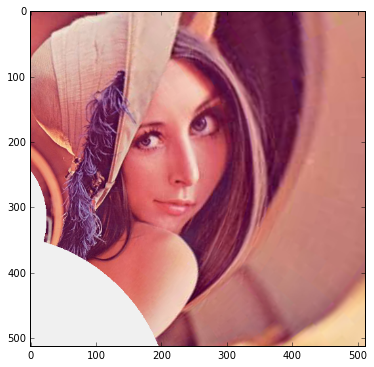

In [10]:
plt.imshow(transformed_img)

Now let us apply the inverse, $T^{-1}$, to our image. Its inverse is just $T$:

In [12]:
def inverse_map(index, a, b, c , d, img): 
    z = index[1] + 1j*(img.shape[0]-1-index[0]) 
    w = (a*z+b)/(c*z+d) 
    return     img.shape[0]-1-np.imag(w), np.real(w), index[2]   

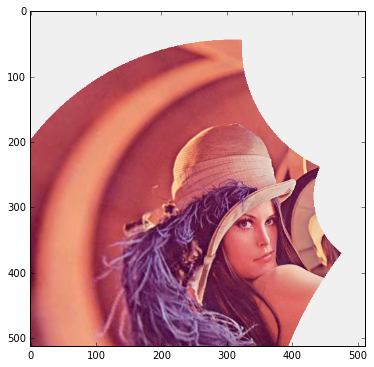

In [14]:
inv_transformed_img = geometric_transform(img, inverse_map, extra_arguments=(a, b,c, d, img), cval=240) 
plt.imshow(inv_transformed_img)

For comparison we plot again all three images:

In [15]:
images=[img, transformed_img, inv_transformed_img]

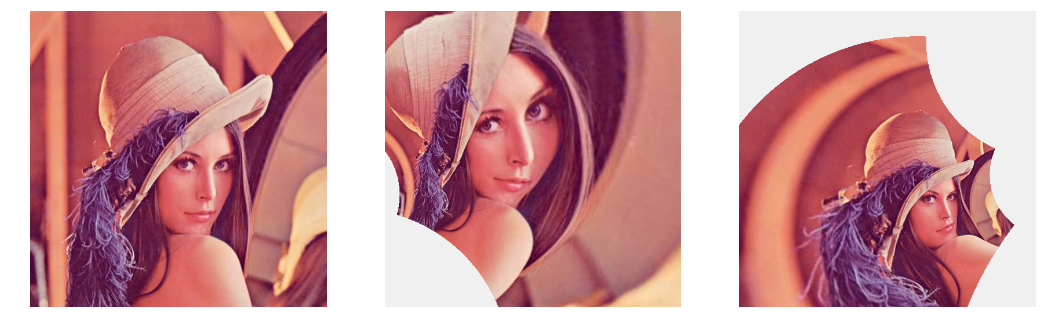

In [16]:
fig = plt.figure(figsize=(18,8))
sbplot = 130
for k in range(3):
    sbplot+=1
    ax = fig.add_subplot(sbplot)
    im=ax.imshow(images[k]) 
    ax.axis('off')

In [17]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()